In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optics, utils
import tifffile
from tqdm import tqdm

def plot_fourier(fourier):
    plt.imshow(np.log(1+np.abs(fourier)))

In [2]:
import napari
viewer = napari.Viewer()

<h1> 1. Field retrieval from hologram </h1>

In [3]:
background = tifffile.imread('background.tif')
sample = tifffile.imread('sample.tif')

N = background[0].shape[0]
Z = background.shape[0]

In [4]:
viewer.add_image(sample)

<Image layer 'sample' at 0x24198362a80>

In [5]:
m = 1
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

# Laser configuration
lam = 532 * nm
NA = 1.2
n_medium = 1
dx_ol = lam / 4 / NA

cutoff = 1/3

In [6]:
params = utils.get_optical_parameters(image_shape=(N, N), lam=lam, n_medium=n_medium, dx_cam=3.5*um, dx_ol=dx_ol)
params

{'dx_cam': 3.5e-06,
 'B_cam': 142857.14285714287,
 'dv_cam': 279.01785714285717,
 'dx_ol': 1.1083333333333335e-07,
 'B_ol': 4511278.195488721,
 'dv_ol': 8811.090225563908,
 'v0': 1879699.2481203005,
 'v_nm': 1879699.2481203005,
 'k_nm': 11810498.697705988,
 's_nm': 213.0}

<h3> object_center gives frequency coordinate of illumination beam in fourier space </h3>

\begin{gather*}


I(\vec{r}) = |R+U|^2 \\
\hat{I(\vec{\nu})} = \mathcal{F} [I(\vec{r})]\\
\mathcal{P} [\hat{I(\vec{\nu})}] = center[cut[\hat{I(\vec{\nu})}]]= center [\mathcal{F} [R^* U]] = \mathcal{F} [U] \\
\Downarrow \\
U(\vec{r}) = \mathcal{F}^{-1} [\mathcal{F} [U]] 


\end{gather*}

<h3> Get object field U : F[(DC term) + UR* + U*R] -> F[U] </h3>

In [7]:
temp_background_object_field, temp_sample_object_field = optics.Holography_Off_Axis.get_object_field(background_hologram=background, 
                                                                                           sample_hologram=sample)

100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


In [9]:
background_object_field = temp_background_object_field / temp_background_object_field
sample_object_field = temp_sample_object_field / temp_background_object_field

<h1> Conjugation test </h1>

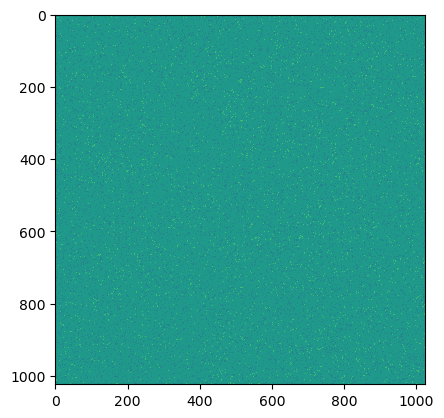

In [25]:
background_object_field = temp_background_object_field * np.conj(temp_background_object_field) / np.abs(temp_background_object_field)**2
sample_object_field = temp_sample_object_field * np.conj(temp_background_object_field) / np.abs(temp_background_object_field)**2
plt.imshow(np.abs(background_object_field[10]))

In [10]:
import utils

s0x = []
s0y = []
s0z = []

for i in range(Z):
    sample_freq = np.array(utils.get_maxindex(np.abs(np.fft.fft2(temp_sample_object_field[i]))))
    if i==0:
        center = sample_freq
    incident_freq = sample_freq-center
    s0x.append(incident_freq[1])
    s0y.append(incident_freq[0])
    s0z.append(round(np.sqrt(params['s_nm']**2 - incident_freq[1]**2 - incident_freq[0]**2)))

In [11]:
s_x = np.arange(-N//2, N//2)
s_y = np.arange(-N//2, N//2)
S_x, S_y = np.meshgrid(s_x, s_y)

S_z = params['s_nm']**2 - S_x**2 - S_y**2
S_z[S_z<0] = 0
S_z = np.sqrt(S_z)


<h1> The first Born </h3>

In [12]:
born_scattered_field = sample_object_field - 1

In [13]:
H = 300
born = np.zeros((N, N, H), dtype=np.complex128)
count = np.zeros((N, N, H))
NA_circle = utils.circular_filter((N, N), pixel_radius=int(params['s_nm']))
for i in tqdm(range(Z)):
    # Shifted coordinates
    shifted_S_x = np.roll(S_x, shift=-s0x[i], axis=1)
    shifted_S_y = np.roll(S_y, shift=-s0y[i], axis=0)
    shifted_S_z = np.roll(S_z, shift=-s0x[i], axis=1)
    shifted_S_z = np.roll(shifted_S_z, shift=-s0y[i], axis=0)
            
    # Scattered field
    Us = born_scattered_field[i].copy()
    fourier_Us = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Us)))
    fourier_Us = fourier_Us * NA_circle
    # fourier_Us = np.roll(fourier_Us, shift=-s0y[i]+1, axis=0)
    # fourier_Us = np.roll(fourier_Us, shift=-s0x[i], axis=1)
            
    # Coefficients
    coeff = 2 * np.pi * params['dv_ol'] * shifted_S_z / 2 / np.pi / 1j
            
    # field
    F_born = coeff * fourier_Us
        
    yx_idx = np.where((S_z>0) & (NA_circle != 0) & 
                    (shifted_S_x > -N//2) & (shifted_S_x < N//2) &
                    (shifted_S_y > -N//2) & (shifted_S_y < N//2)
                )
        
    # yx_idx = np.where((S_z>0))
        
    z_idx = np.round(shifted_S_z[yx_idx]-shifted_S_z[N//2, N//2] + H//2).astype(int)
    yxz_idx = (yx_idx[0], yx_idx[1], z_idx)
    count[yxz_idx] += np.ones((N, N, H))[yxz_idx]
            
    born[yxz_idx] += F_born[yx_idx]  
    
born[count==0] = 0
born[count!=0] = born[count!=0]/count[count!=0]

100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


In [14]:
potential = np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(born)))
viewer.add_image(np.real(potential))

<Image layer 'Image' at 0x2419a5ec260>

In [222]:
ri = np.sqrt(1 + 4 * np.pi * potential / params['k_nm']**2)
viewer.add_image(np.real(ri))

<Image layer 'Image [1]' at 0x15da469a660>

<h1> The first Rytov </h1>

In [26]:
# Rytov
H = 300
rytov = np.zeros((N, N, H), dtype=np.complex128)
count = np.zeros((N, N, H))
NA_circle = utils.circular_filter((N, N), pixel_radius=int(params['s_nm']))
for i in tqdm(range(Z)):
    
    rytov_field = np.log(np.abs(sample_object_field[i])) + 1j * np.angle(sample_object_field[i])
    
    # Shifted coordinates
    shifted_S_x = np.roll(S_x, shift=-s0x[i], axis=1)
    shifted_S_y = np.roll(S_y, shift=-s0y[i], axis=0)
    shifted_S_z = np.roll(S_z, shift=-s0x[i], axis=1)
    shifted_S_z = np.roll(shifted_S_z, shift=-s0y[i], axis=0)

    # Scattered field
    Us = rytov_field.copy()
    fourier_Us = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Us)))
    fourier_Us = fourier_Us * NA_circle
    # fourier_Us = np.roll(fourier_Us, shift=-s0y[i]+1, axis=0)
    # fourier_Us = np.roll(fourier_Us, shift=-s0x[i], axis=1)
            
    # Coefficients
    coeff = 2 * np.pi * params['dv_ol'] * shifted_S_z / 2 / np.pi / 1j
            
    # field
    F_rytov = coeff * fourier_Us
        
    yx_idx = np.where((S_z>0) & (NA_circle != 0) & 
                (shifted_S_x > -N//2) & (shifted_S_x < N//2) &
                (shifted_S_y > -N//2) & (shifted_S_y < N//2)
                )
        
    # yx_idx = np.where((S_z>0))
        
    z_idx = np.round(shifted_S_z[yx_idx]-shifted_S_z[N//2, N//2] + H//2).astype(int)
    yxz_idx = (yx_idx[0], yx_idx[1], z_idx)
    count[yxz_idx] += np.ones((N, N, H))[yxz_idx]
            
    rytov[yxz_idx] += F_rytov[yx_idx]
    
rytov[count==0] = 0
rytov[count!=0] = rytov[count!=0]/count[count!=0]

100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


In [30]:
potential = np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(rytov)))
viewer.add_image(np.real(potential))

<Image layer 'Image' at 0x241d9f4b230>

In [29]:
viewer.add_image(np.imag(potential))

<Image layer 'Image' at 0x241d9e2ed20>

In [307]:
ri = np.sqrt(1 + 4 * np.pi * np.real(potential) / params['k_nm']**2)
viewer.add_image(np.real(ri))

<Image layer 'ri' at 0x15dc5486c00>